# Wiener Hammerstein System

Note: The example shown in this notebook is taken from the companion book [Nonlinear System Identification and Forecasting: Theory and Practice with SysIdentPy](https://sysidentpy.org/book/0-Preface/).

The description content primarily derives from the [benchmark website - Nonlinear Benchmark](https://www.nonlinearbenchmark.org/benchmarks) and [associated paper - Wiener-Hammerstein benchmark with process noise](https://data.4tu.nl/articles/_/12952124). For a detailed description, readers are referred to the linked references.

> The nonlinear benchmark website stands as a significant contribution to the system identification and machine learning community. The users are encouraged to explore all the papers referenced on the site.

This benchmark focuses on a Wiener-Hammerstein electronic circuit where process noise plays a significant role in distorting the output signal.

The Wiener-Hammerstein structure is a well-known block-oriented system which contains a static nonlinearity sandwiched between two Linear Time-Invariant (LTI) blocks (Figure 2). This arrangement presents a challenging identification problem due to the presence of these LTI blocks.


![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/wh_system.png?raw=true)
> Figure 2: the Wiener-Hammerstein system

In Figure 2, the Wiener-Hammerstein system is illustrated with process noise $e_x(t)$ entering before the static nonlinearity $f(x)$, sandwiched between LTI blocks represented by $R(s)$ and $S(s)$ at the input and output, respectively. Additionally, small, negligible noise sources $e_u(t)$ and $e_y(t)$ affect the measurement channels. The measured input and output signals are denoted as $u_m(t)$ and $y_m(t)$.

The first LTI block $R(s)$ is effectively modeled as a third-order lowpass filter. The second LTI subsystem $S(s)$ is configured as an inverse Chebyshev filter with a stop-band attenuation of $40 dB$ and a cutoff frequency of $5 kHz$. Notably, $S(s)$ includes a transmission zero within the operational frequency range, complicating its inversion.

The static nonlinearity $f(x)$ is implemented using a diode-resistor network, resulting in saturation nonlinearity. Process noise $e_x(t)$ is introduced as filtered white Gaussian noise, generated from a discrete-time third-order lowpass Butterworth filter followed by zero-order hold and analog low-pass reconstruction filtering with a cutoff of $20 kHz$.

Measurement noise sources $e_u(t)$ and $e_y(t)$ are minimal compared to $e_x(t)$. The system's inputs and process noise are generated using an Arbitrary Waveform Generator (AWG), specifically the Agilent/HP E1445A, sampling at $78125 Hz$, synchronized with an acquisition system (Agilent/HP E1430A) to ensure phase coherence and prevent leakage errors. Buffering between the acquisition cards and the system's inputs and outputs minimizes measurement equipment distortion.

The benchmark provides two standard test signals through the benchmarking website: a random phase multisine and a sine-sweep signal. Both signals have an $rms$ value of $0.71 Vrms$ and cover frequencies from DC to $15 kHz$ (excluding DC). The sine-sweep spans this frequency range at a rate of $4.29 MHz/min$. These test sets serve as targets for evaluating the model's performance, emphasizing accurate representation under varied conditions.

The Wiener-Hammerstein benchmark highlights three primary nonlinear system identification challenges:

1. **Process Noise:** Significant in the system, influencing output fidelity.
2. **Static Nonlinearity:** Indirectly accessible from measured data, posing identification challenges.
3. **Output Dynamics:** Complex inversion due to transmission zero presence in $S(s)$.

The goal of this benchmark is to develop and validate robust models using separate estimation data, ensuring accurate characterization of the Wiener-Hammerstein system's behavior.

### Required Packages and Versions

To ensure that you can replicate this case study, it is essential to use specific versions of the required packages. Below is a list of the packages along with their respective versions needed for running the case studies effectively.

To install all the required packages, you can create a `requirements.txt` file with the following content:

```
sysidentpy==0.4.0
pandas==2.2.2
numpy==1.26.0
matplotlib==3.8.4
nonlinear_benchmarks==0.1.2
```

Then, install the packages using:
```
pip install -r requirements.txt
```

- Ensure that you use a virtual environment to avoid conflicts between package versions.
- Versions specified are based on compatibility with the code examples provided. If you are using different versions, some adjustments in the code might be necessary.

### SysIdentPy configuration

In this section, we will demonstrate the application of SysIdentPy to the Wiener-Hammerstein system dataset.  The following code will guide you through the process of loading the dataset, configuring the SysIdentPy parameters, and building a model for Wiener-Hammerstein system.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sysidentpy.model_structure_selection import FROLS, AOLS, MetaMSS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.utils.display_results import results
from sysidentpy.parameter_estimation import (
    LeastSquares,
    BoundedVariableLeastSquares,
    NonNegativeLeastSquares,
    LeastSquaresMinimalResidual,
)

from sysidentpy.metrics import root_mean_squared_error
from sysidentpy.utils.plotting import plot_results

import nonlinear_benchmarks

train_val, test = nonlinear_benchmarks.WienerHammerBenchMark(atleast_2d=True)
x_train, y_train = train_val
x_test, y_test = test

We used the `nonlinear_benchmarks` package to load the data. The user is referred to the [package documentation](https://github.com/GerbenBeintema/nonlinear_benchmarks/tree/master) to check the details of how to use it.

The following plot detail the training and testing data of the experiment.

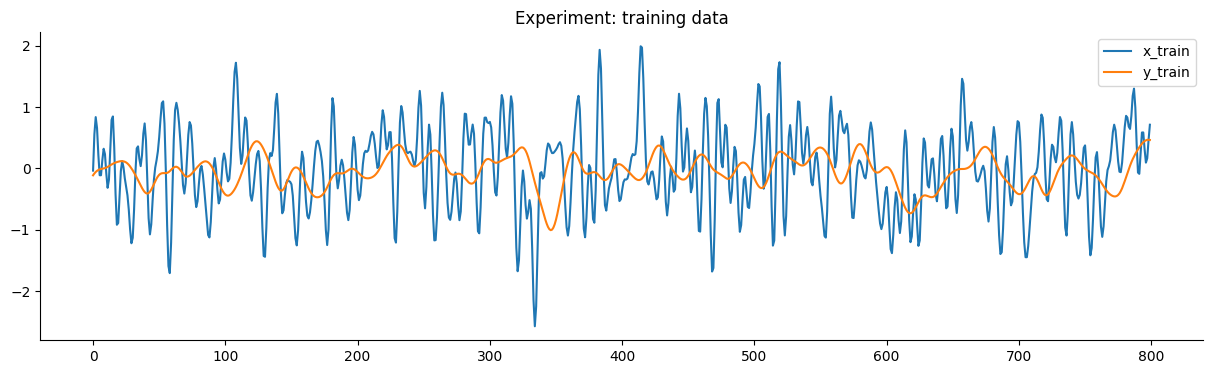

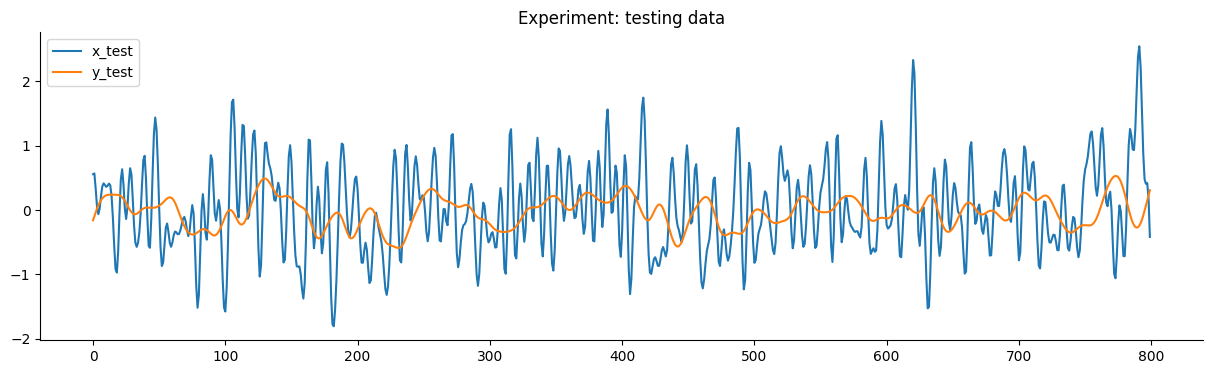

In [2]:
plot_n = 800

plt.figure(figsize=(15, 4))
plt.plot(x_train[:plot_n])
plt.plot(y_train[:plot_n])
plt.title("Experiment: training data")
plt.legend(["x_train", "y_train"])
plt.show()

plt.figure(figsize=(15, 4))
plt.plot(x_test[:plot_n])
plt.plot(y_test[:plot_n])
plt.title("Experiment: testing data")
plt.legend(["x_test", "y_test"])
plt.show()

The goal of this benchmark it to get a model that have a better performance than the SOTA model provided in the benchmarking paper.

![](https://github.com/wilsonrljr/sysidentpy-data/blob/4085901293ba5ed5674bb2911ef4d1fa20f3438d/book/assets/wh_sota_results.png?raw=true)
> State of the art results presented in the [benchmarking paper](https://arxiv.org/pdf/2405.10779). In this section we are only working with the Wiener-Hammerstein results, which are presented in the $W-H$  column.

### Results

We will start with a basic configuration of FROLS using a polynomial basis function with degree equal 2. The `xlag` and `ylag` are set to $7$ in this first example. Because the dataset is considerably large, we will start with `n_info_values=50`. This means the FROLS algorithm will not include all regressors when calculating the information criteria used to determine the model order. While this approach might result in a sub-optimal model, it is a reasonable starting point for our first attempt.

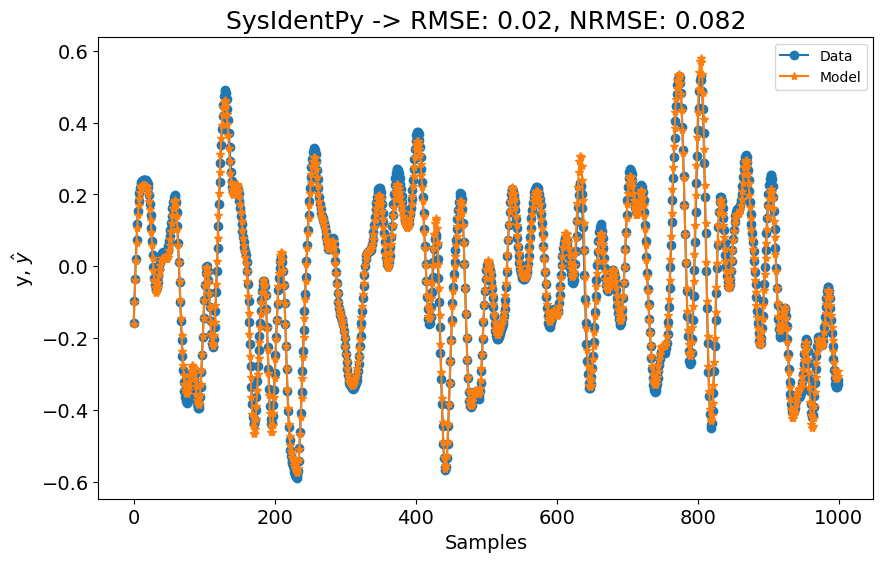

In [ ]:
# 3min to run in my machine (amd 5600x, 32gb ram)

n = test.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=7,
    ylag=7,
    basis_function=basis_function,
    estimator=LeastSquares(unbiased=False),
    n_info_values=50,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
rmse_sota = rmse / y_test.std()
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=1000,
    title=f"SysIdentPy -> RMSE: {round(rmse, 4)}, NRMSE: {round(rmse_sota, 4)}",
)

The first configuration is already better than the **SOTA** models shown in the benchmark table! We started using `xlag=ylag=7` to have an idea of how well SysIdentPy would handle this dataset, but the results are pretty good already! However, the benchmarking paper indicates  that they used higher lags for their models. Let's check what happens if we set `xlag=ylag=10`.

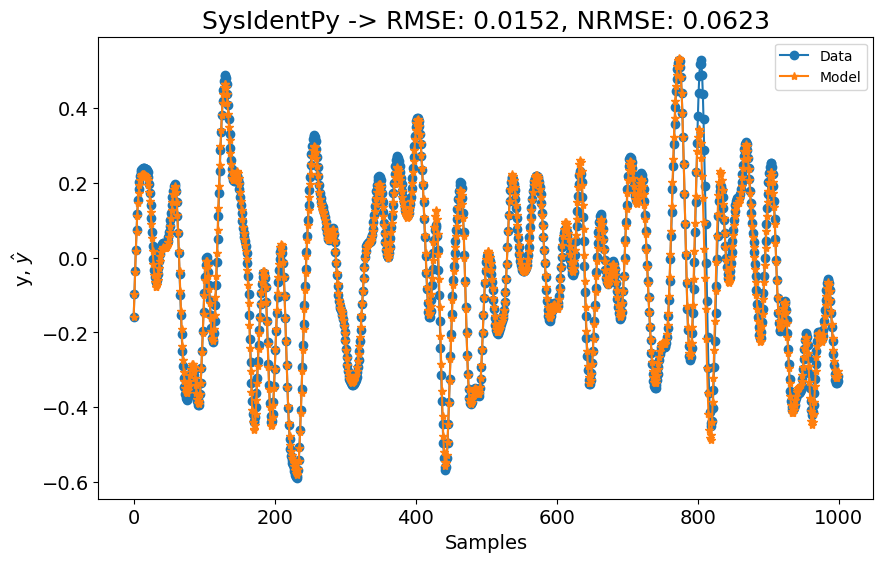

In [4]:
# 7min to run in my machine (amd 5600x, 32gb ram)

x_train, y_train = train_val
x_test, y_test = test

n = test.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=10,
    ylag=10,
    basis_function=basis_function,
    estimator=LeastSquares(unbiased=False),
    n_info_values=50,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
rmse_sota = rmse / y_test.std()
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=1000,
    title=f"SysIdentPy -> RMSE: {round(rmse, 4)}, NRMSE: {round(rmse_sota, 4)}",
)

The performance is even better now! For now, we are not worried about the model complexity (even in this case where we are comparing to a deep state neural network...). However, if we check the model order and the `AIC` plot, we see that the model have 50 regressors , but the `AIC` values do not change much after each added regression.

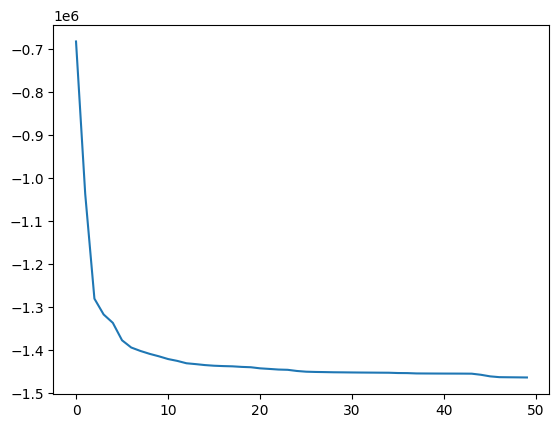

In [5]:
plt.plot(model.info_values)

So, what happens if we set a model with half of the regressors?

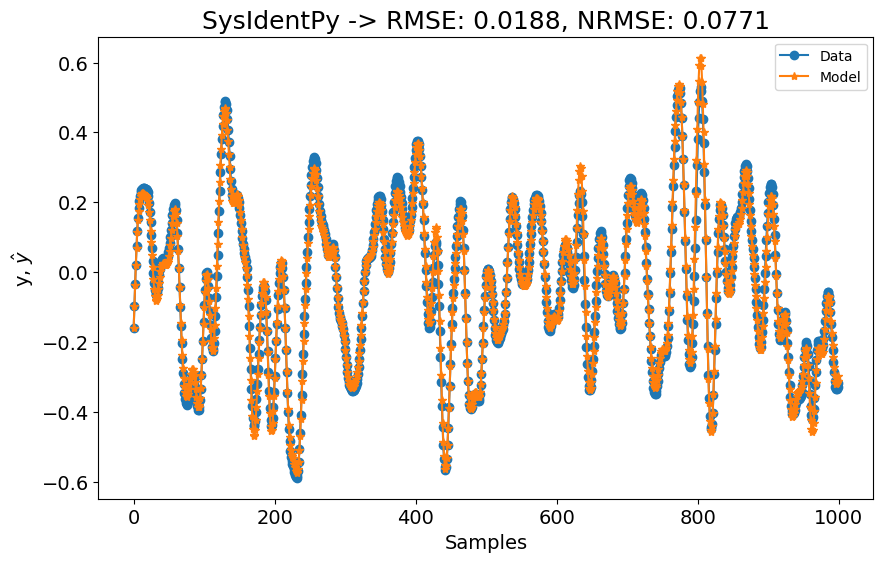

In [ ]:
# 14 seconds to run

x_train, y_train = train_val
x_test, y_test = test

n = test.state_initialization_window_length

basis_function = Polynomial(degree=2)
model = FROLS(
    xlag=10,
    ylag=10,
    basis_function=basis_function,
    estimator=LeastSquares(unbiased=False),
    n_info_values=50,
    n_terms=25,
    order_selection=False,
)

model.fit(X=x_train, y=y_train)
y_test = np.concatenate([y_train[-model.max_lag :], y_test])
x_test = np.concatenate([x_train[-model.max_lag :], x_test])
yhat = model.predict(X=x_test, y=y_test[: model.max_lag, :])
rmse = root_mean_squared_error(y_test[model.max_lag + n :], yhat[model.max_lag + n :])
rmse_sota = rmse / y_test.std()
plot_results(
    y=y_test[model.max_lag :],
    yhat=yhat[model.max_lag :],
    n=1000,
    title=f"SysIdentPy -> RMSE: {round(rmse, 4)}, NRMSE: {round(rmse_sota, 4)}",
)

As shown in the figure above, the results still outperform the SOTA models presented in the benchmarking paper. The SOTA results from the paper could likely be improved as well. Users are encouraged to explore the [deepsysid package](https://github.com/AlexandraBaier/deepsysid), which can be used to build deep state neural networks.

This basic configuration can serve as a starting point for users to develop even better models using SysIdentPy. Give it a try!